In [1]:
!pip install shap


Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 25.3 -> 26.0.1
[notice] To update, run: C:\Users\Emma\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [2]:
# import
import shap
import joblib
import pandas as pd
from sklearn.model_selection import train_test_split

C:\Users\Emma\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


##Chargement du dataset

In [3]:
# Chargement
df = pd.read_csv('df_clean.csv')

In [4]:
# Encodage de la variable cible
df["Patient's Vital Status"] = df["Patient's Vital Status"].map({"Dead":1, "Alive":0})
df = df.dropna(subset=["Patient's Vital Status"])

In [5]:
# Split stratifié
X = df.drop(columns=["Patient's Vital Status"])
y = df["Patient's Vital Status"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

In [6]:
# Conversion des booléens en str pour OneHot
for col in X_train.select_dtypes(include="bool").columns:
    X_train[col] = X_train[col].astype(str)
    X_test[col] = X_test[col].astype(str)

print("OK — X_test est prêt :", X_test.shape)

OK — X_test est prêt : (38, 6)


##Chargement du pipeline entrainé

In [7]:
pipe = joblib.load("data/processed/best_model.pkl")

##Récupération des données preprocessées

In [8]:
X_test_processed = pipe.named_steps["preprocessor"].transform(X_test)
X_train_processed = pipe.named_steps["preprocessor"].transform(X_train)


##Vérifier le type de modèle

In [9]:
type(pipe.named_steps["model"])

sklearn.linear_model._logistic.LogisticRegression

In [10]:
preprocessor = pipe.named_steps["preprocessor"]
feature_names = preprocessor.get_feature_names_out()

##SHAP pour XGBOOST

In [11]:
# création de l'explainer
model = pipe.named_steps["model"]
explainer = shap.LinearExplainer(model, X_train_processed) # mettre TreeExplainer si autre modèle

# calcul des valeurs de SHAP
shap_values = explainer.shap_values(X_test_processed)


##Affichage Global

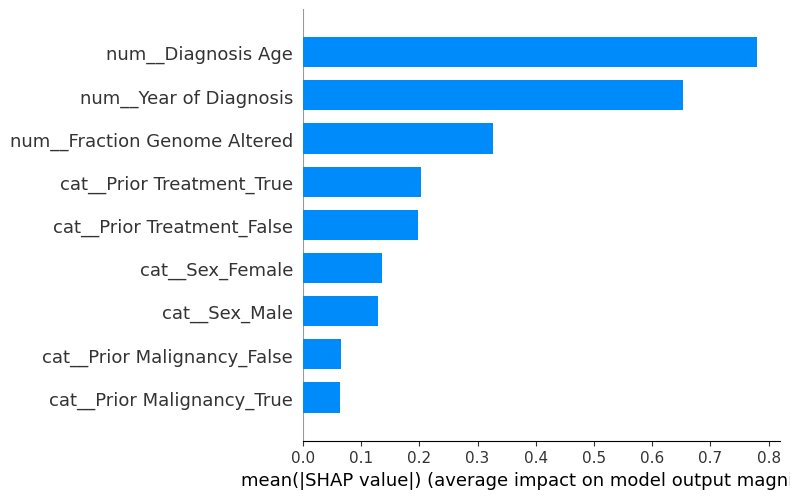

In [12]:
shap.summary_plot(shap_values, X_test_processed, feature_names=feature_names, plot_type="bar")

Conclusion Notebook 5
Le modèle Logistic Regression entraîné a été analysé avec SHAP pour identifier l’importance des features.

La visualisation globale (summary_plot) montre quelles variables influencent le plus la prédiction de la survie des patients AML.

Cette analyse améliore la transparence du modèle, ce qui est essentiel pour des décisions en contexte clinique.